## Phần khám phá dữ liệu

Tải dữ liệu từ kaggle bằng opendatasets, hoặc tải trực tiếp từ

In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('dataset.csv')
df.head() 

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [299]:
df.shape

(6417106, 5)

In [300]:
df.describe(include='all')

,app_id,app_name,review_text,review_score,review_votes
count,6.417106e+06,6233872,6409801,6.417106e+06,6.417106e+06
unique,NaN,9363,4473473,NaN,NaN
top,NaN,PAYDAY 2,Early Access Review,NaN,NaN
freq,NaN,88973,1013351,NaN,NaN
mean,2.274695e+05,NaN,NaN,6.394992e-01,1.472446e-01
std,1.260451e+05,NaN,NaN,7.687918e-01,3.543496e-01
min,1.000000e+01,NaN,NaN,-1.000000e+00,0.000000e+00
25%,2.018100e+05,NaN,NaN,1.000000e+00,0.000000e+00
50%,2.391600e+05,NaN,NaN,1.000000e+00,0.000000e+00
75%,3.056200e+05,NaN,NaN,1.000000e+00,0.000000e+00


In [301]:
df.isnull().values.any()

True

In [302]:
df.isnull().sum()

app_id               0
app_name        183234
review_text       7305
review_score         0
review_votes         0
dtype: int64

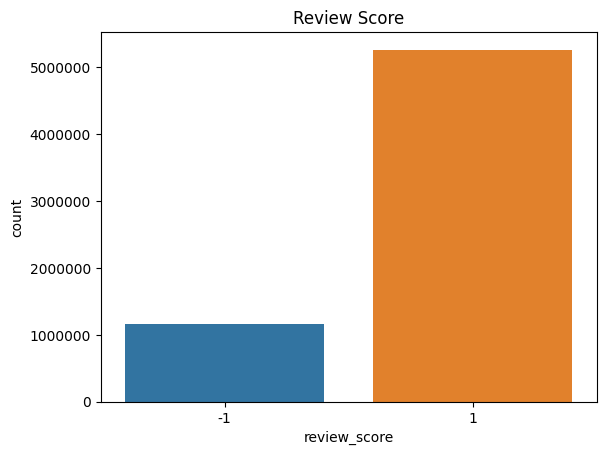

In [303]:
sns.countplot(x="review_score", data=df).set_title('Review Score')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [304]:
reviews_text = df['review_text'].reset_index(name='text')
# Đếm tần suất xuất hiện của các từ lặp lại trong review_text
tc = reviews_text['text'].value_counts().reset_index(name='count')
tc.rename(columns={'index': 'text'}, inplace=True)
tc.head(10)

,text,count
0,Early Access Review,1013351
1,Early Access Review,11334
2,10/10,6147
3,.,4885
4,Great game,3710
5,great game,3642
6,Great game!,2493
7,:),2140
8,Nice game,1839
9,♥♥♥♥,1711


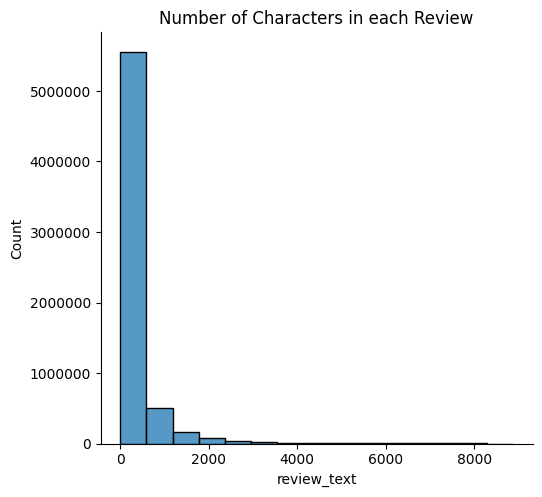

In [305]:
sns.displot(df["review_text"].str.len(), kde=False, bins=15)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Number of Characters in each Review')
plt.show()

In [306]:
round(df["review_text"].str.len().mean())

304

In [307]:
# Number of review with review_vote = 1
df[df['review_votes'] == 1].shape[0]

944884

### Word Cloud

In [308]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

def WordCloud_generator(data, title=None):
    
    # Keep top 1000 most frequent words
    most_freq = Counter(data).most_common(1000) 
    text = ' '.join([x[0] for x in most_freq])
    
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10,
                          collocations=False
                         ).generate(text)

    # plot the Word Cloud                      
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

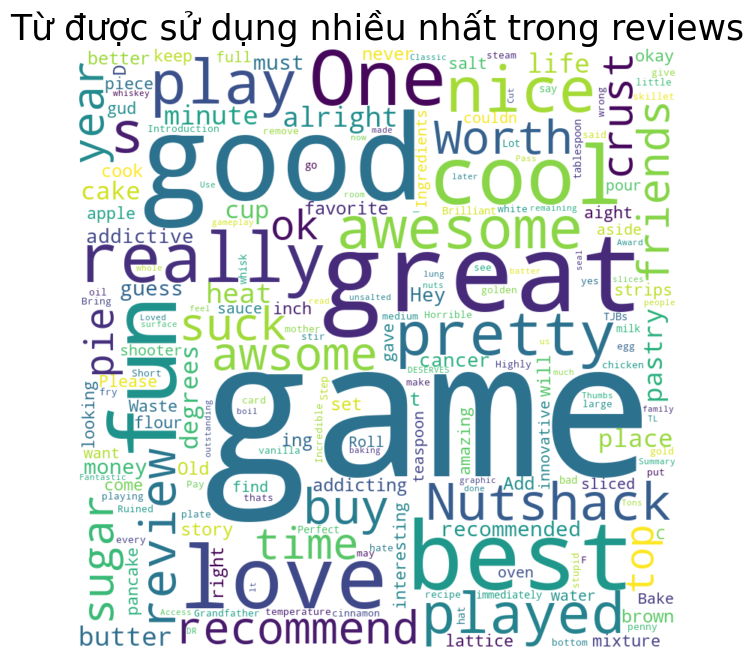

In [309]:
WordCloud_generator(df["review_text"].astype(str),
title="Từ được sử dụng nhiều nhất trong reviews")

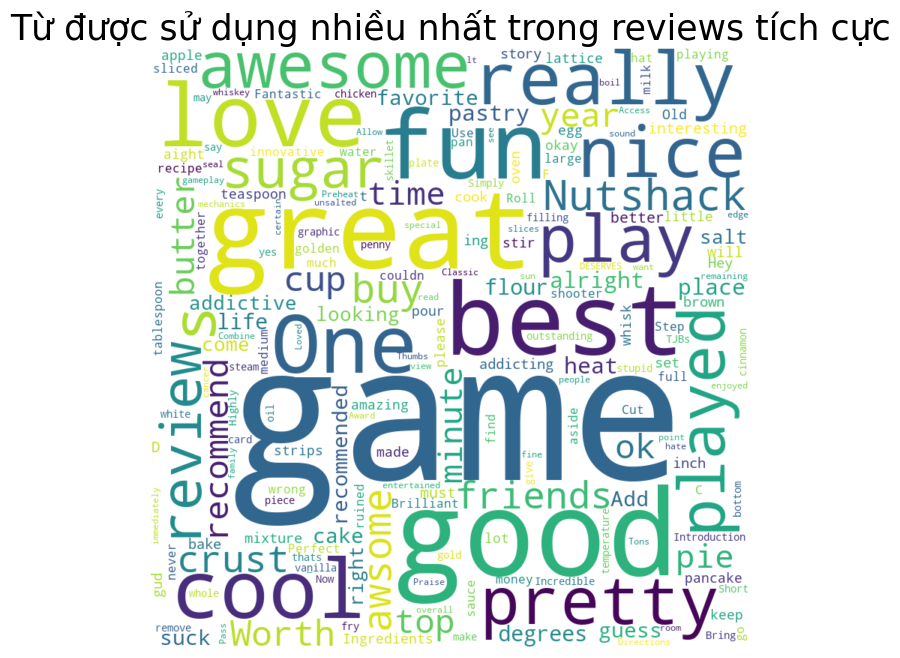

In [310]:
WordCloud_generator(df[df["review_score"]==1]["review_text"].astype(str), 
title="Từ được sử dụng nhiều nhất trong reviews tích cực")

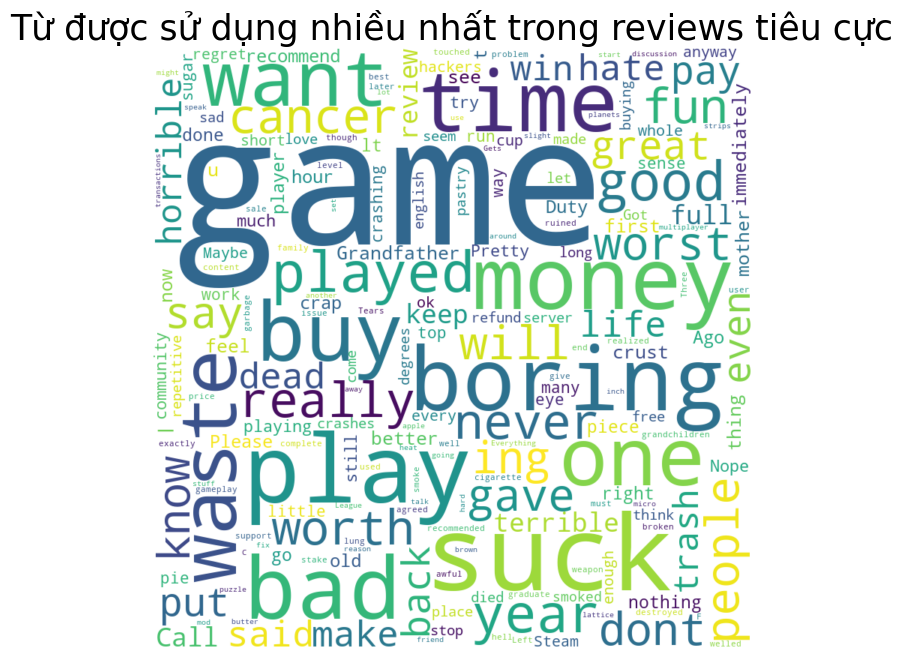

In [311]:
WordCloud_generator(df[df["review_score"]==-1]["review_text"].astype(str), 
title="Từ được sử dụng nhiều nhất trong reviews tiêu cực")

## Tiền xử lý dữ liệu (Preprocessing)

Phần xử lý chuỗi nằm ở trong module 'utils.py' và được import vào đây.

In [312]:
df = df.drop(['app_id', 'app_name'], axis=1)
df = df.dropna(subset=['review_text'])

In [313]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['review_score'] = labelencoder.fit_transform(df['review_score'])

In [314]:
np.random.seed(42)
sample_id = np.random.choice(df.index, 15000, replace=False)
data = df.copy() # Copy dataframe từ df qua data
# lấy 15000 dòng của 2 cột review_text và review_score
data = data.loc[sample_id, ['review_text', 'review_score']]
# Bỏ đi các dòng có Early Access Review
data = data[data['review_text'].str.contains('Early Access Review') == False]  

In [315]:
reviews_text = data['review_text'].reset_index(name='text') # Đặt lại index cho cột review_text
# Đếm tần suất xuất hiện của các từ lặp lại trong review_text sau khi tiền xử lý
tc = reviews_text['text'].value_counts().reset_index(name='count')
tc.rename(columns={'index': 'text'}, inplace=True)
tc.head(10) 

,text,count
0,great game,11
1,Great game,9
2,10/10,9
3,.,7
4,Nice game,7
5,Great game!,5
6,Great,5
7,♥♥♥♥,4
8,its good,4
9,It's alright.,4


### Chia tập dữ liệu thành 2 tập: train và test

In [316]:
from sklearn.model_selection import train_test_split
X = data.review_text # feature
y = data.review_score # label
# chia theo tỉ lệ 8/2.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Chuyển dữ liệu về dạng số

In [317]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from utils import *

new_stopwords = stopwords.words('english')
# Trong các từ dừng, ta cần giữ lại các từ sau, vì có vai trò 
# ngữ nghĩa quan trọng trong câu.
new_stopwords.remove('not')
new_stopwords.remove('nor')
new_stopwords.remove('never')

custom_stopwords = []

for w in new_stopwords:
    custom_stopwords.append(stem_tokenizer(preprocess_review(w))[0])

custom_vect = CountVectorizer(preprocessor=preprocess_review, 
                             tokenizer=stem_tokenizer,
                             stop_words=custom_stopwords,
                             max_features=8000)

X_train_vect = custom_vect.fit_transform(X_train)

c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  warnings.warn(


In [318]:
from collections import Counter # đếm số lượng các class
from imblearn.over_sampling import SMOTE # cân bằng dữ liệu
imbalanced = Counter(y_train)
print(f'Kích thước tập dữ liệu ban đầu')
print(f'0: {imbalanced[0]}, 1: {imbalanced[1]}')
sm = SMOTE(random_state=1142) # random_state để đảm bảo kết quả luôn như nhau
X_train_res, y_train_res = sm.fit_resample(X_train_vect, y_train)
balanced = Counter(y_train_res)
print(f'Kích thước tập dữ liệu sau khi cân bằng')
print(f'0: {balanced[0]}, 1: {balanced[1]}')

Kích thước tập dữ liệu ban đầu
0: 1781, 1: 8347
Kích thước tập dữ liệu sau khi cân bằng
0: 8347, 1: 8347


## Mô hình học máy

### Logistic Regression

In [319]:
from sklearn.linear_model import LogisticRegression
logres = LogisticRegression(C=10, penalty='l2') # C là trọng số chuẩn hóa, penalty là hàm chuẩn hóa
logres.fit(X_train_res, y_train_res)

c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

### Naive Bayes

In [320]:
from sklearn.naive_bayes import MultinomialNB
# Khong co lam min
nbWithoutSmoothing = MultinomialNB(alpha=0, force_alpha=True)
# Co lam min, vi gia tri default cua alpha la 1.0
nbWithSmoothing = MultinomialNB()
nbWithSmoothing.fit(X_train_res, y_train_res)
nbWithoutSmoothing.fit(X_train_res, y_train_res)

c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


MultinomialNB(alpha=0, force_alpha=True)

### Support Vector Machine

In [321]:
# from sklearn.svm import SVC
# svc1 = SVC(kernel='linear', C=10)
# svc2 = SVC(kernel='rbf', C=10, gamma=0.1)
# svc1.fit(X_train_res, y_train_res)
# svc2.fit(X_train_res, y_train_res)

### Decision Tree và Random Forest

In [322]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

tree1 = DecisionTreeClassifier(max_depth=100, max_features='auto', criterion='entropy',min_samples_leaf=1, min_samples_split=30)
tree2 = RandomForestClassifier(max_depth=10, n_estimators=100, max_features=1) 
tree1.fit(X_train_res, y_train_res)
tree2.fit(X_train_res, y_train_res)

c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


RandomForestClassifier(max_depth=10, max_features=1)

### Thuật toán boosting

#### XGBoost

In [323]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42) # objective: phan loai gi, random_state: đảm bảo kết quả luôn như nhau
xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

#### CatBoost

In [324]:
# from catboost import CatBoostClassifier
# cat = CatBoostClassifier(iterations=100, learning_rate=0.01, depth=16, loss_function='Logloss')
# cat.fit(X_train_res, y_train_res)

## Học Sâu


### Xử lý dữ liệu cho mô hình học sâu

In [325]:
import torch
import torch.nn as nn
import torchtext.vocab as vocab
from torch.utils.data import DataLoader, Dataset

In [326]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
torch.manual_seed(SEED)

In [327]:
np.random.seed(42)
sample_id = np.random.choice(df.index, 300000, replace=False) # lấy ngẫu nhiên 300000 dòng, replace=False để không lấy trùng
data = df.copy()
data = data.loc[sample_id, ['review_text', 'review_score']] # lấy 300000 dòng của 2 cột review_text và review_score
data = data[data['review_text'].str.contains('Early Access Review') == False] 

In [328]:
train_data, validate_data = train_test_split(data, test_size=0.2)
validate_data, test_data = train_test_split(validate_data, test_size=0.5)
train_data.shape, test_data.shape, validate_data.shape

((201878, 2), (25235, 2), (25235, 2))

In [329]:
tokens_count = Counter()
for line in data.review_text:
    tokens_count.update(tokenizer(preprocess_review(line)))
print(f'So luong cac token: {len(tokens_count)}')

In [ ]:
from torchtext.vocab import vocab

In [ ]:
from collections import OrderedDict
sorted_by_freq_tuples = sorted(tokens_count.items(), 
                               key=lambda x: x[1], 
                               reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
vocab_review = vocab(ordered_dict) # 
# padding
vocab_review.insert_token('<pad>', 0)
# unknown
vocab_review.insert_token('<unk>', 1)
vocab_review.set_default_index(1)
print(f'Vocabulary size: {len(vocab_review)}')
print([vocab_review[token] for token in 
      ['my','whole','live','i','have','tried']])

Vocabulary size: 180817
[33, 295, 777, 8, 20, 480]


In [ ]:
text_pipeline = lambda x: [vocab_review[token] for token in tokenizer(x)]
label_pipeline = lambda x: 1. if x == 1 else 0.  # we need float labels for BCEWithLogitsLoss

def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        if not isinstance(_text, str):
            continue
        processed_text = torch.tensor(text_pipeline(_text),
                                      dtype=torch.int64)
        if processed_text.size(0) > 0:
            label_list.append(label_pipeline(_label))
            text_list.append(processed_text)
            lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    return padded_text_list, label_list, lengths

# check a small batch
tmp = DataLoader(list(zip(df.review_score, df.review_text)), batch_size=4, shuffle = False, collate_fn = collate_batch)
text_batch, label_batch, length_batch = next(iter(tmp))
print('text batch:', text_batch)
print('label batch:', label_batch)
print('length batch:', length_batch)
print('text batch shape:', text_batch.shape)

text batch: tensor([[   1,   33,  224,  ...,    0,    0,    0],
        [   1,   32,   26,  ...,  824,  129,    1],
        [   1,    7, 2149,  ...,    0,    0,    0],
        [   1,    1,   10,  ...,    0,    0,    0]])
label batch: tensor([1., 1., 1., 1.])
length batch: tensor([  4, 510,   6,  55])
text batch shape: torch.Size([4, 510])


In [ ]:
batch_size = 32
train_dl = DataLoader(list(zip(train_data.review_score, train_data.review_text)), batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch) # 
valid_dl = DataLoader(list(zip(validate_data.review_score, validate_data.review_text)), batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(list(zip(test_data.review_score, test_data.review_text)), batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        # sentence embedding
        self.embedding = nn.Embedding(num_embeddings = vocab_size, 
                                      embedding_dim = embed_dim, 
                                      padding_idx = 0)
        # RNN layer
        # input dimensions are: (batch, seq, feature) 
        self.rnn = nn.RNN(input_size = embed_dim, 
                           hidden_size = rnn_hidden_size, 
                           batch_first = True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, text, lengths):
        out = self.embedding(text)
        # pad sententences with zero, lengths are the before padded
        out = nn.utils.rnn.pack_padded_sequence(out, 
                                                lengths.cpu().numpy(), 
                                                enforce_sorted = False, 
                                                batch_first = True)
        # output, hidden state
        # hidden state shape: D*num_layers, batch size, out_dim
        out, hidden = self.rnn(out)
        out = hidden[-1,:,:] # -1;:,: means last layer, all batches, all hidden units
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
torch.manual_seed(SEED)
vocab_size = len(vocab_review)
embed_dim = 10
rnn_hidden_size = 8
fc_hidden_size = 4
model_rnn = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)
model_rnn

RNN(
  (embedding): Embedding(180817, 10, padding_idx=0)
  (rnn): RNN(10, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

In [ ]:
def acc(pred, y):
    pred = torch.round(torch.sigmoid(pred))
    correct = (pred == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, dataloader):
    model.train()
    total_acc, total_loss = 0., 0.
    for batch_idx, (text_batch, label_batch, lengths) in enumerate(dataloader):
        text_batch = text_batch.to(device)
        label_batch = label_batch.to(device)
        pred = model(text_batch, lengths)[:, 0]  # only get the last output
        loss = loss_fn(pred, label_batch.float())  # loss function
        optimizer.zero_grad()  # clear gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update weights
        correct_pred = (pred >= 0.5).float() == label_batch
        total_acc += correct_pred.float().sum().item()
        total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)
def evaluate(model, dataloader):
    model.eval() 
    total_acc, total_loss = 0., 0.
    with torch.no_grad(): # No need to backpropagation
        for text_batch, label_batch, lengths in dataloader:
            text_batch = text_batch.to(device)
            label_batch = label_batch.to(device)
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch.float())
            total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

Trường hợp kernel bị crash khi training, hãy chạy dl.ipynb để train các model học sâu.

In [ ]:
import os

if os.path.exists('model/rnn.pth'):
      model_rnn.load_state_dict(torch.load('model/rnn.pth'))
      print('Load model successfully')
else:
      num_epochs = 5
      torch.manual_seed(SEED)
      loss_hist_train = [0] * num_epochs
      accuracy_hist_train = [0] * num_epochs
      loss_hist_valid = [0] * num_epochs
      accuracy_hist_valid = [0] * num_epochs
      for epoch in range(num_epochs):
            model_rnn.to(device)
            acc_train, loss_train = train(model_rnn,train_dl)
            acc_valid, loss_valid = evaluate(model_rnn, valid_dl)
            print(f'Epoch {epoch} accuracy: {acc_train:.4f}'
                  f' val_accuracy: {acc_valid:.4f}')
            loss_hist_train[epoch] = loss_train
            accuracy_hist_train[epoch] = acc_train
            loss_hist_valid[epoch] = loss_valid
            accuracy_hist_valid[epoch] = acc_valid
      my_dpi = 100
      fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(540/my_dpi, 720/my_dpi), dpi=my_dpi)
      ax[0].plot(loss_hist_train, lw=2)
      ax[0].plot(loss_hist_valid, lw=2)
      ax[0].legend(['Train loss', 'Validation loss'], fontsize=12)
      ax[0].set_xlabel('Epochs', size=12)
      ax[1].plot(accuracy_hist_train, lw=2)
      ax[1].plot(accuracy_hist_valid, lw=2)
      ax[1].legend(['Train acc.', 'Validation acc.'], fontsize=12)
      ax[1].set_xlabel('Epochs', size=12);
      plt.tight_layout()
      plt.savefig(f'model_train_history_rnn.png', dpi = my_dpi);
      torch.save(model_rnn.state_dict(), 'model/lstm.pth')

Load model successfully


In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_hidden_size, fc_hidden_size):
        super().__init__()
        # sentence embedding
        self.embedding = nn.Embedding(num_embeddings = vocab_size, 
                                      embedding_dim = embed_dim, 
                                      padding_idx = 0)
        self.lstm = nn.LSTM(input_size = embed_dim, 
                           hidden_size = lstm_hidden_size, 
                           batch_first = True)
        self.fc1 = nn.Linear(lstm_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)  # Adding a dropout layer
        
    def forward(self, text, lengths):
        out = self.embedding(text)
        # pad sententences with zero, lengths are the before padded
        out = nn.utils.rnn.pack_padded_sequence(out, 
                                                lengths.cpu().numpy(), 
                                                enforce_sorted = False, 
                                                batch_first = True)
        # output, hidden state
        # hidden state shape: D*num_layers, batch size, out_dim
        out, (hidden, cell) = self.lstm(out) 
        out = hidden[-1,:,:]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Applying dropout to the output
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
torch.manual_seed(SEED)
vocab_size = len(vocab_review)
embed_dim = 10
lstm_hidden_size = 8
fc_hidden_size = 4
model_lstm = LSTM(vocab_size, embed_dim, lstm_hidden_size, fc_hidden_size)
model_lstm

LSTM(
  (embedding): Embedding(180817, 10, padding_idx=0)
  (lstm): LSTM(10, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr = 0.001)

In [ ]:
if os.path.exists('model/lstm.pth'):
      model_lstm.load_state_dict(torch.load('model/lstm.pth'))
      print('Load model successfully')
else:
      num_epochs = 5
      torch.manual_seed(SEED)
      loss_hist_train = [0] * num_epochs
      accuracy_hist_train = [0] * num_epochs
      loss_hist_valid = [0] * num_epochs
      accuracy_hist_valid = [0] * num_epochs
      for epoch in range(num_epochs):
            model_lstm.to(device)
            acc_train, loss_train = train(model_lstm,train_dl)
            acc_valid, loss_valid = evaluate(model_lstm, valid_dl)
            print(f'Epoch {epoch} accuracy: {acc_train:.4f}'
                  f' val_accuracy: {acc_valid:.4f}')
            loss_hist_train[epoch] = loss_train
            accuracy_hist_train[epoch] = acc_train
            loss_hist_valid[epoch] = loss_valid
            accuracy_hist_valid[epoch] = acc_valid
      my_dpi = 100
      fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(540/my_dpi, 720/my_dpi), dpi=my_dpi)
      ax[0].plot(loss_hist_train, lw=2)
      ax[0].plot(loss_hist_valid, lw=2)
      ax[0].legend(['Train loss', 'Validation loss'], fontsize=12)
      ax[0].set_xlabel('Epochs', size=12)
      ax[1].plot(accuracy_hist_train, lw=2)
      ax[1].plot(accuracy_hist_valid, lw=2)
      ax[1].legend(['Train acc.', 'Validation acc.'], fontsize=12)
      ax[1].set_xlabel('Epochs', size=12);
      plt.tight_layout()
      plt.savefig(f'model_train_history_lstm.png', dpi = my_dpi);
      torch.save(model_lstm.state_dict(), 'model/lstm.pth')

Load model successfully


## Đánh giá hiệu suất mô hình

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# Sklearn model, take in model, x_test, y_test
def evaluate_sklearn(model, x_test, y_test):
    x_test = custom_vect.fit_transform(x_test)
    y_pred = model.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')
    print(f'Recall: {recall_score(y_test, y_pred):.4f}')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    print(f'Specificity: {specificity:.4f}')
    print(f'F1: {f1_score(y_test, y_pred):.4f}')
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.5266
Precision: 0.8291
Recall: 0.5432
Specificity: 0.4447
F1: 0.6563


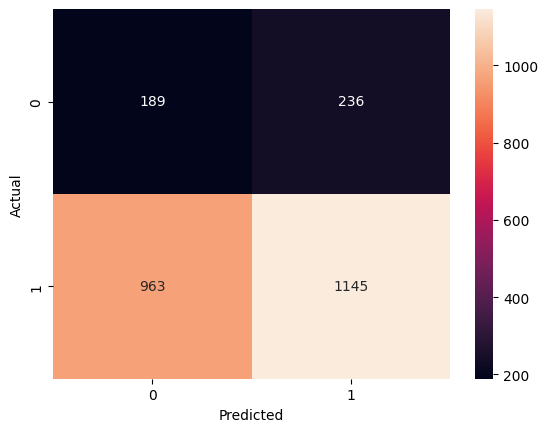

In [ ]:
# Logistic Regression
evaluate_sklearn(logres, X_test, y_test)

c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.7418
Precision: 0.8308
Recall: 0.8662
Specificity: 0.1247
F1: 0.8481


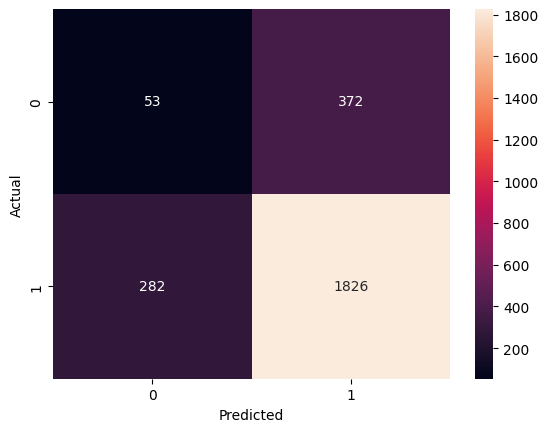

In [ ]:
# Naive Bayes
evaluate_sklearn(nbWithSmoothing, X_test, y_test)

c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.6407
Precision: 0.8544
Recall: 0.6850
Specificity: 0.4212
F1: 0.7604


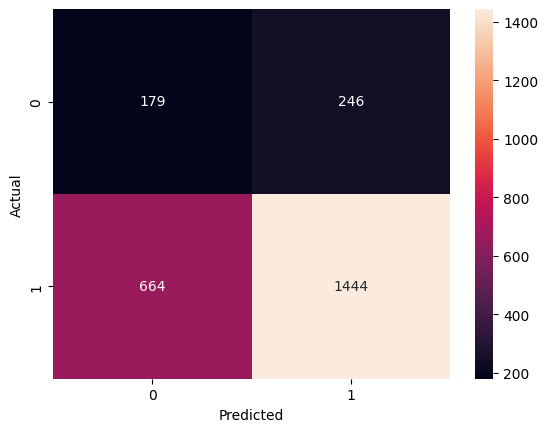

In [ ]:
# Without smoothing
evaluate_sklearn(nbWithoutSmoothing, X_test, y_test) 

In [ ]:
# SVM (Linear)
evaluate_sklearn(svc1, X_test, y_test)

NameError: name 'svc1' is not defined

c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.6060
Precision: 0.8157
Recall: 0.6803
Specificity: 0.2376
F1: 0.7419


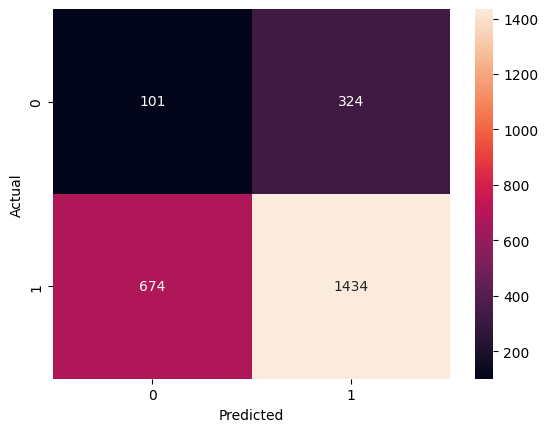

In [ ]:
# SVM (RBF)
evaluate_sklearn(svc2, X_test, y_test)

c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.2771
Precision: 0.7904
Recall: 0.1788
Specificity: 0.7647
F1: 0.2917


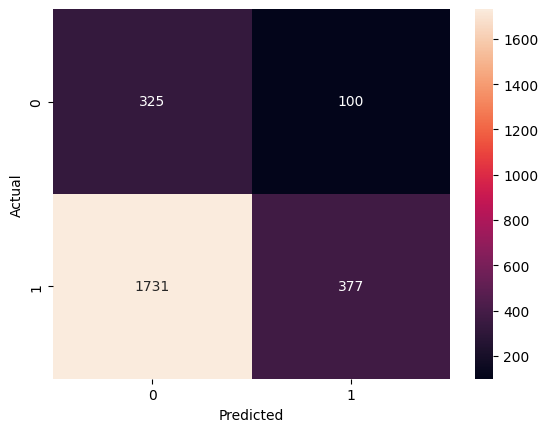

In [ ]:
# Decision Tree
evaluate_sklearn(tree1, X_test, y_test)

c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.4955
Precision: 0.8083
Recall: 0.5161
Specificity: 0.3929
F1: 0.6300


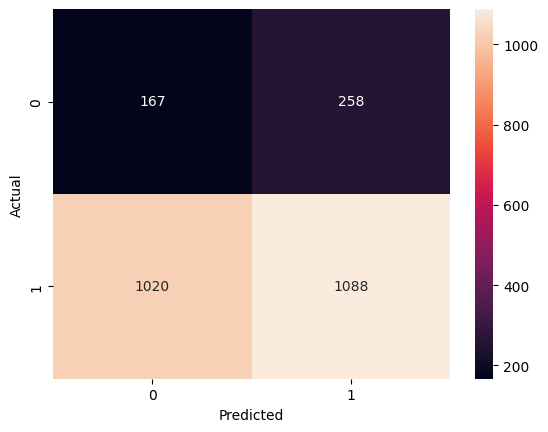

In [ ]:
# Random Forest
evaluate_sklearn(tree2, X_test, y_test)

c:\Users\tatra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.8137
Precision: 0.8350
Recall: 0.9673
Specificity: 0.0518
F1: 0.8963


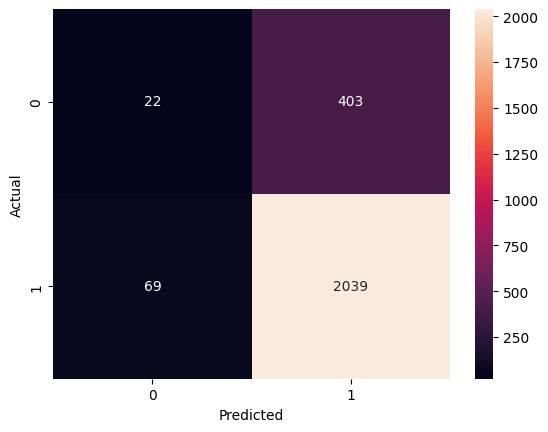

In [ ]:
# XGBoost
evaluate_sklearn(xgb_model, X_test, y_test)

In [ ]:
# CatBoost
evaluate_sklearn(cat, X_test, y_test)

NameError: name 'cat' is not defined

In [ ]:
# Evaluate deep learning model(s), return accuracy, precision, recall, f1 score, confusion matrix
def evaluate_dl(model, dataloader):
    model.to(device)
    model.eval()
    total_acc, total_loss = 0., 0.
    y_pred = []
    y_true = []
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            text_batch = text_batch.to(device)
            label_batch = label_batch.to(device)
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch.float())
            correct_pred = (pred >= 0.5).float() == label_batch
            total_acc += correct_pred.float().sum().item()
            total_loss += loss.item() * label_batch.size(0)
            y_pred.extend((pred >= 0.5).float().cpu().numpy())
            y_true.extend(label_batch.cpu().numpy())
    print(f'Accuracy: {accuracy_score(y_true, y_pred):.4f}')
    print(f'Precision: {precision_score(y_true, y_pred):.4f}')
    print(f'Recall: {recall_score(y_true, y_pred):.4f}')
    # Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    print(f'Specificity: {specificity:.4f}')
    print(f'F1: {f1_score(y_true, y_pred):.4f}')
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Accuracy: 0.8621
Precision: 0.9063
Recall: 0.9296
Specificity: 0.5363
F1: 0.9178


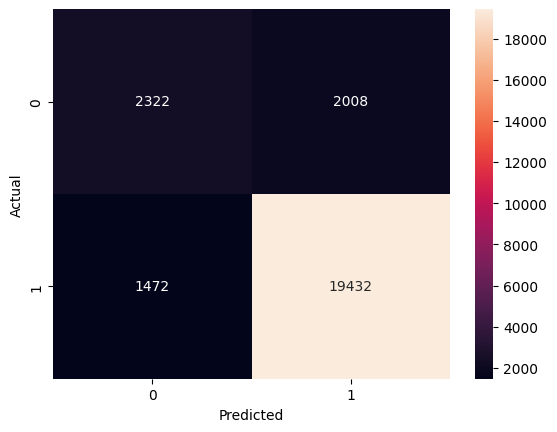

In [ ]:
# RNN
evaluate_dl(model_rnn, test_dl)

Accuracy: 0.8855
Precision: 0.9293
Recall: 0.9327
Specificity: 0.6575
F1: 0.9310


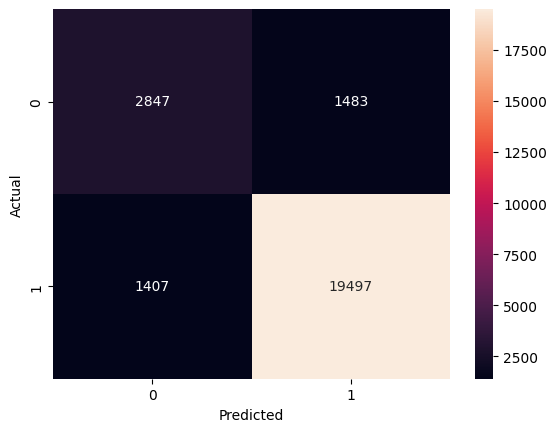

In [ ]:
# LSTM
evaluate_dl(model_lstm, test_dl)

### Thử dự đoán mẫu 5 câu ngẫu nhiên bằng hai mô hình tốt nhất

In [ ]:
import random

model_rnn.to(device)
model_rnn.eval()


with torch.no_grad():
    for x_batch, y_batch, lengths in test_dl:
        break
        
x_batch = x_batch.to(device)
pred = model_rnn(x_batch, lengths)[:, 0]

# Randomly select 5 indices
random_indices = random.sample(range(len(x_batch)), k=5)

for i in random_indices:
    print('\nReview text:', ' '.join([vocab_review.get_itos()[j] for j in x_batch[i] if j != 0]))
    print('True label =', y_batch[i].item(),', model prediction', pred[i].item())


Review text: <unk> the best game i have ever played
True label = 1.0 , model prediction 0.9851265549659729

Review text: <unk> nice game i recommend it for people who liked the previous civ games
True label = 1.0 , model prediction 0.9837918281555176

Review text: <unk> game is giving me motion sickness purely by the way the screen moves when walking <unk> It also does <unk> work great with a touchpad <unk> ca <unk> drag the mouse and use buttons at the same time <unk> but I guess that <unk> more my fault for misplacing my usb mouse rather than the game <unk> fault <unk> <unk> <unk> <unk> obtaining a mouse and playing again I have completely changed my mind <unk> <unk> <unk> worth the motion sickness to play this game <unk> <unk> story really sucks you in and its beautifully made <unk>
True label = 1.0 , model prediction 0.6994114518165588

Review text: I <unk> <unk> <unk> I <unk> <unk> <unk> <unk> <unk> A <unk> <unk> <unk> LIKE <unk> <unk> <unk> <unk> <unk> <unk> <unk> DAY <unk> <unk

In [ ]:
import random

model_lstm.to(device)
model_lstm.eval()

with torch.no_grad():
    for x_batch, y_batch, lengths in test_dl:
        break

x_batch = x_batch.to(device)
pred = model_lstm(x_batch, lengths)[:, 0]

# Randomly select 5 indices with review_text length < 150
random_indices = random.sample(range(len(x_batch)), k=5)

for i in random_indices:
    print('\nReview text:', ' '
          .join([vocab_review.get_itos()[j] for j in x_batch[i] if j != 0]))
    print('True label =', y_batch[i].item(), ', model prediction', pred[i].item())



Review text: <unk> played is miss leading <unk> I played this game before getting on <unk> <unk> <unk> wasted at least <unk> hours playing if not way more <unk> I have played the <unk> games from the beginning <unk> <unk> a great story of the lone wonderer who fixes so much yet really ends up with little in the end <unk> I can say I was quite the fan of the original end game <unk> <unk> not spoil it if you have not played it <unk> <unk> thing I suggest is if you are having problems <unk> do a search on mod sites to find compatabiltiy patches or you will crash a lot <unk> <unk> that is done <unk> mods mods mods <unk> <unk> friendly and some wonderful full on adventure mods out there <unk> <unk> you are a fan of <unk> <unk> <unk> <unk> they have all kinds of armor representing the different chapters and even bolt guns <unk> etc <unk> <unk> story as you start in a vault and end up leaving to explore the world <unk> <unk> well on its own <unk> <unk> you have played <unk> 1 and 2 <unk> you

In [ ]:
# Using XGBoost to predict 5 random reviews from test set
random_indices = random.sample(range(len(X_test)), k=5)
for i in random_indices:
    print('\nReview text:', X_test.iloc[i])
    print('True label =', y_test.iloc[i],', model prediction', nbWithSmoothing.predict_proba(custom_vect.transform([X_test.iloc[i]]))[0][1])


Review text: You'll experience a better story and more of a fun time getting a refund.
True label = 0 , model prediction 0.9998966524177378

Review text: I cannot recommend this game at all due to the technical issues I had with it. Having installed it I was frozen out of my computer requiring a full reboot twice, once for entering the options screen and attempting to adjust the options and once for attempting top select my charatcer to begin a game. Beware
True label = 0 , model prediction 0.9985532056274161

Review text: Menu music is jimi Hendrix' version of Star Spangled Banner. 10/10
True label = 1 , model prediction 0.9660018932763803

Review text: If you like playing no-limit Hold 'Em and you are a fan of these characters, there's enough friendly (and competitive) banter to keep you amused for a few hours at the least. If you play TF2, you get unlocks as a bonus for demolishing the competition.
True label = 1 , model prediction 0.9999982360699488

Review text: Tired of all RPG/

In [ ]:
random_indices = random.sample([i for i in range(len(X_test)) if len(X_test.iloc[i]) < 120], k=5)
for i in random_indices:
    print('\nReview text:', X_test.iloc[i])
    print('True label =', y_test.iloc[i],', model prediction', xgb_model.predict_proba(custom_vect.transform([X_test.iloc[i]]))[0][1])


Review text: Got to switch to killer after blood pressure on heart attack border, give people the feeling im getting. 10/10 see me!
True label = 1 , model prediction 0.7164286

Review text: Gameplay is easy and rewarding.  But...  I'm only playing for the achievements to make my profile look dope.
True label = 1 , model prediction 0.6857522

Review text: Poorly optimized console port. I dont care if you give us some balance changes when you cant fix your ♥♥♥♥♥♥♥ game
True label = 0 , model prediction 0.6857522

Review text: I need to spend more hours on this
True label = 1 , model prediction 0.6857522

Review text: Really fun game to play with your mates
True label = 1 , model prediction 0.6857522


In [ ]:
# FInd 5 random reviews with true label = 0 and model prediction = 0 
# (correctly classified as negative reviews)
random_indices = [i for i in range(len(y_test)) if y_test.iloc[i] == 0 and xgb_model.predict_proba(custom_vect.transform([X_test.iloc[i]]))[0][1] < 0.4]
random_indices = random.sample(random_indices, k=5)
for i in random_indices:
    print('\nReview text:', X_test.iloc[i])
    print('True label =', y_test.iloc[i],', model prediction', xgb_model.predict_proba(custom_vect.transform([X_test.iloc[i]]))[0][1])



Review text: Let me preface this by saying I only recommend this game if you are invested in the trilogy's story, because it does end the trilogy and the story did have it's moments. But as an overall game, it gets a C+ in comparison to Arkham City's A+ in my books.  This review is not about the ineptitude and failure to deliver a good port, or how the game runs. Because for me the game ran perfectly fine. I have a system that could run it at 60fps just fine. I was one of the lucky ones.  Therefore I waited until I completed the game, and this will be a review of the actual game itself, and will contain spoilers. For Knight and for Arkham City, maybe a little for Asylum, because I have to make this comparison.  If you were to ask me which of the Arkham games was the best. Far and away it would be City. Knight in comparison feels, lazy, and the Batmobile segments feel forced, far too often do you use the Batmobile for miniscule things, like Riddler tasks. Why would the Riddler design a

In [ ]:
# Normal model
def predict_sklearn(model):
    text = input('Enter your review: ')
    text = custom_vect.transform([text])
    # Return probability of prediction
    pred = model.predict_proba(text)[0]
    if pred[1] > 0.5:
        print(f'Positive review with probability {pred[1]:.4f}')
    else:
        print(f'Negative review with probability {pred[0]:.4f}')
# Deep learning model
def predict_dl(model):
    text = input('Enter your review: ')
    model.eval()
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text), dtype=torch.int64).to(device)
        text = text.unsqueeze(0) # batch size = 1
        length = torch.tensor([text.size(1)], dtype=torch.int64)
        pred = model(text, length)
        if pred >= 0.5:
            print(f'Positive review with probability {pred.item():.4f}')
        else:
            print(f'Negative review with probability {1-pred.item():.4f}')

In [ ]:
predict_sklearn(nbWithSmoothing)

Negative review with probability 0.6230


In [ ]:
predict_dl(model_lstm)

Negative review with probability 0.6418
